we have:

    at q state
    po q state
    po m div
    po q div
    at q zip3
    at y zip3
    at y tract
    
at y state -> at y county -> at y tract    

or 

at y state -> at y zip3 -> at y zip5  

a zip code may be shared by two couties. a tract may have multiple zips.


po m div -> po q state -> at y state -> at y county -> at y tract

or 

po m div -> po q state -> at y state -> at y zip3 -> at y zip5



# state_monthly

In [1]:
%reset -f

In [2]:
%pylab inline
import pandas as pd
import dask.dataframe as dd
import os,sys
import logging
import fastparquet
import gc
import cPickle as pickle 

Populating the interactive namespace from numpy and matplotlib


In [3]:
def read_po_monthly_hpi():
    df=pd.read_csv("../input/third2/HPI_PO_monthly_hist.csv", parse_dates=['Month'])
    #df=df[df['state'].isin({'IA','CA','NY','NC','OH'})]
    cols=[u for u in df.columns if 'NSA' in u] +['Month']
    df=df[cols]
    cols=[u.split('(')[0].strip() for u in df.columns]
    df.columns=cols
    df=df[['Month','Middle Atlantic','East North Central','West North Central', 'South Atlantic','Pacific']]
    df=df[df.Month>=pd.to_datetime('1991-1-1')]
    df=df.set_index('Month')
    df.columns=["MA",'ENC','WNC','SA','PAC']
    assert df.isnull().sum().sum()==0
    return df
def read_po_monthly_hpi():
    df=pd.read_csv("../input/third2/HPI_PO_monthly_hist_with_forecast.csv", parse_dates=[0])
    df.columns=['Month']+list(df.columns[1:])
    df=df[df['Month']<pd.to_datetime('2019-1-1')]
    df=df.set_index(['Month'])
    df=df[["MA",'ENC','WNC','SA','PAC']]
    assert df.isnull().sum().sum()==0
    return df

In [4]:
div_po_monthly=read_po_monthly_hpi()

In [5]:
div_po_monthly.tail()

MA         ENC         WNC          SA         PAC
Month                                                                 
2018-08-01  244.584604  224.448794  272.288133  275.515458  318.638901
2018-09-01  243.597944  226.374702  269.999277  275.880371  318.091299
2018-10-01  244.804319  226.315802  268.901616  277.947724  320.694880
2018-11-01  241.312560  225.968267  268.631761  279.515680  321.900547
2018-12-01  245.728476  225.981601  268.141916  277.845004  324.682659

In [6]:
div_po_monthly.index.max()

Timestamp('2018-12-01 00:00:00')

In [7]:
def read_po_state_quarterly_hpi():
    df=pd.read_csv("../input/third2/HPI_PO_state.txt" ,sep="\t")
    df=df[df['state'].isin({'IA','CA','NY','NC','OH'})]
    df['hpi']=df['index_nsa'].astype(np.float)
    df=df[df.yr>1990]
    df['Month']=pd.to_datetime(df.apply(lambda u: '{}-{}-{}'.format(u['yr'], (u['qtr']-1)*3+2,1),axis=1))
    df=df.drop(['index_nsa','index_sa','Warning'],axis=1)
    assert df.isnull().sum().sum()==0
    df=pd.pivot_table(df, columns='state',values='hpi', index=['Month'])
    df=df[["NY", "OH", "IA", "NC", "CA"]]
    return df
def read_po_state_quarterly_hpi():
    df=pd.read_csv("../input/third2/HPI_state_PO_quarterly_hist_with_forecast.csv", parse_dates=[0])
    df.columns=['Month']+list(df.columns[1:])
    df=df[df['Month']<pd.to_datetime('2019-1-1')]    
    df['Month']=df['Month'].map(lambda u: pd.to_datetime('{}-{}-1'.format(u.year,u.month+1)))
    df=df.set_index(['Month'])
    df=df[["NY", "OH", "IA", "NC", "CA"]]
    return df


In [8]:
state_po_quarterly=read_po_state_quarterly_hpi()

In [9]:
state_po_quarterly.index.max()

Timestamp('2018-11-01 00:00:00')

In [10]:
state_po_quarterly.head()

NY      OH      IA      NC      CA
Month                                             
1991-02-01  100.00  100.00  100.00  100.00  100.00
1991-05-01   99.54  101.49  101.24  100.48   99.68
1991-08-01  100.09  101.94  102.55  100.16   99.54
1991-11-01  100.37  102.85  103.16  101.74   99.68
1992-02-01  101.00  104.23  103.80  102.05   99.04

In [11]:
src=div_po_monthly.sort_index()
target=state_po_quarterly.sort_index()

In [12]:
dest=target[target.index<pd.to_datetime('1800-1-1')]
assert len(dest)==0
dest=dest.reindex(src.index)

In [13]:
col_map={'CA': 'PAC', 'IA': 'WNC', 'NC': 'SA', 'NY': 'MA', 'OH': 'ENC'}

In [14]:
from dateutil.relativedelta import relativedelta

In [15]:
def make_quarter(dt):
    assert dt.month in {2,5,8,11}
    return [dt - relativedelta(months=1),dt,dt + relativedelta(months=1)]

In [16]:
def make_src_ratio(src,dt):
    quarter_dts1=make_quarter(dt)
    quarter_dts2=make_quarter(dt-relativedelta(months=3))
    return src.loc[quarter_dts1].values/src.loc[quarter_dts2].values


In [17]:
make_quarter(target.index[0])

[Timestamp('1991-01-01 00:00:00'),
 Timestamp('1991-02-01 00:00:00'),
 Timestamp('1991-03-01 00:00:00')]

In [18]:
def make_series(src_s, target_s):
    lst=[]
    for i, dt in enumerate(target_s.index):
        quarter_dts=make_quarter(dt)
        svs=src_s.loc[quarter_dts]
        if i==0:
            lst.append(svs.values)
        else:
            tv2=target_s.iloc[i]
            tv1=target_s.iloc[i-1]
            last_quarter=lst[-1]
            r=make_src_ratio(src_s,dt)
            k= tv2/tv1/np.mean(r)
            #k=np.exp(np.log(tv2/tv1) - np.mean(np.log(r)))
            
            #print last_quarter, r,k,tv2,tv1,k
            lst.append(k*r*last_quarter)
    lst=np.concatenate(lst,axis=0)
    return lst
            


In [19]:
dest=[]
for col in target.columns:
    target_s=target[col]
    src_s=src[col_map[col]]
    dest_s= make_series(src_s,target_s)
    dest.append(dest_s)
dest=pd.DataFrame( np.array(dest).T,columns=target.columns,index=src.index)

NY MA


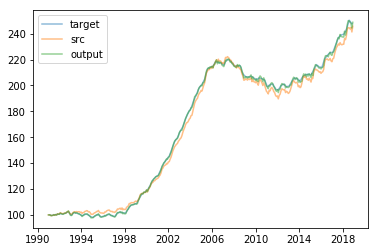

OH ENC


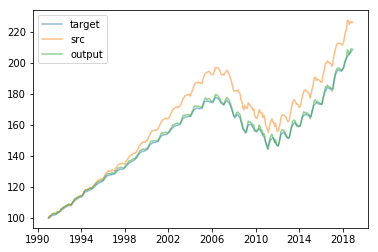

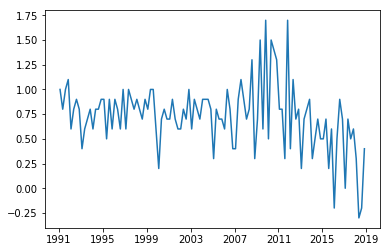

IA WNC


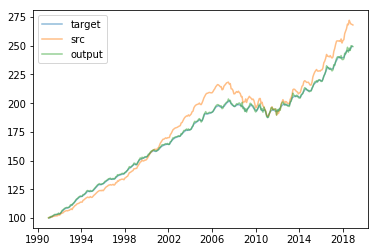

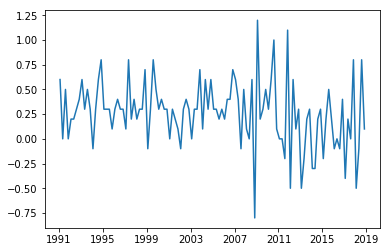

NC SA


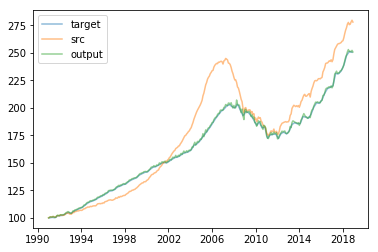

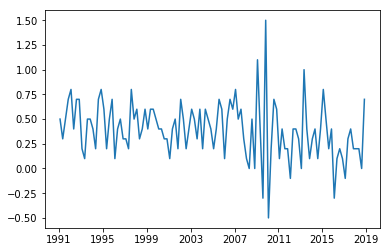

CA PAC


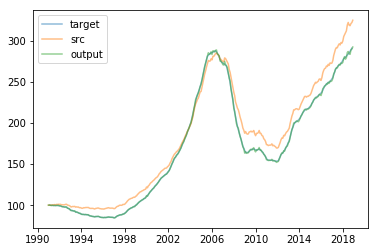

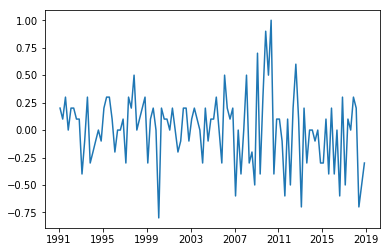

In [20]:
for i in range(len(dest.columns)):
    print dest.columns[i], src.columns[i]
    plt.plot(target.iloc[:,i],alpha=0.5)
    plt.plot(src.iloc[:,i],alpha=0.5)
    plt.plot(dest.iloc[:,i],alpha=0.5)
    plt.legend(['target','src','output'])
    plt.show()
    plt.plot( np.round(100*(dest.iloc[:,i]/target.iloc[:,i]-1),1).dropna())
    plt.show()

In [21]:
dest.tail()

NY          OH          IA          NC          CA
Month                                                                 
2018-08-01  249.918980  205.107320  248.052295  251.029849  283.737456
2018-09-01  248.910801  206.867266  245.967165  251.362332  283.249834
2018-10-01  247.845010  208.946399  250.070775  250.776382  288.602463
2018-11-01  244.309881  208.625537  249.819818  252.191060  289.687478
2018-12-01  248.780646  208.637848  249.364276  250.683704  292.191179

In [22]:
dest.to_csv("../input/third2/HPI_po_state_monthly.csv")

# zip3 monthly

In [23]:
%reset -f

In [24]:
%pylab inline
import pandas as pd
import dask.dataframe as dd
import os,sys
import logging
import fastparquet
import gc
import cPickle as pickle 

Populating the interactive namespace from numpy and matplotlib


In [25]:
state_po_monthly=pd.read_csv("../input/third2/HPI_po_state_monthly.csv", parse_dates=['Month']).set_index('Month')
print state_po_monthly.columns
state_po_monthly.columns=['36','39','19','37','06']

Index([u'NY', u'OH', u'IA', u'NC', u'CA'], dtype='object')


In [26]:
state_po_monthly.head()

36          39          19          37          06
Month                                                                 
1991-01-01  100.000000  100.000000  100.000000  100.000000  100.000000
1991-02-01  100.040000  101.000000  100.610000  100.520000  100.210000
1991-03-01   99.930000  101.350000  100.410000  100.970000  100.000000
1991-04-01   99.330001  101.730924  101.466203  100.888174   99.574089
1991-05-01   99.590001  102.350747  101.245012  100.748274   99.812685

In [27]:
state_po_monthly.index.max()

Timestamp('2018-12-01 00:00:00')

In [28]:
zip3_at_hpi=pd.read_csv("../input/third2/HPI_AT_BDL_zip3_5state.csv", dtype={'zip3':np.str}).set_index("zip3").T
zip3_at_hpi.index=pd.to_datetime(['{}-07-01'.format(u) for u in zip3_at_hpi.index])

In [29]:
zip3_at_hpi.index.max()

Timestamp('2018-07-01 00:00:00')

In [30]:
zip3_at_hpi.tail()

zip3               028         054         057         063         068  \
2014-07-01  616.740000  609.240000  276.450000  323.060000  662.380000   
2015-07-01  641.350000  621.310000  276.480000  324.820000  677.380000   
2016-07-01  671.410000  632.320000  279.540000  328.790000  680.050000   
2017-07-01  712.740000  650.680000  284.510000  341.900000  684.020000   
2018-07-01  754.070007  669.039978  289.480011  355.009979  687.990051   

zip3               070         072         074         076         100  \
2014-07-01  731.530000  495.430000  721.650000  782.240000  299.776900   
2015-07-01  753.660000  511.770000  734.840000  799.560000  308.227630   
2016-07-01  776.650000  533.630000  750.970000  823.190000  318.764560   
2017-07-01  808.000000  574.110000  763.780000  857.350000  333.064670   
2018-07-01  839.349976  614.589966  776.590088  891.509949  347.364763   

zip3          ...              954         955         956         957  \
2014-07-01    ...       973.000000  597.720000  702.110000  681.750000   
2015-07-01    ...      1043.670000  623.000000  737.550000  706.410000   
2016-07-01    ...      1135.290000  663.070000  796.570000  755.620000   
2017-07-01    ...      1231.450000  719.240000  870.880000  822.500000   
2018-07-01    ...      1327.609863  775.409973  945.190002  889.380005   

zip3                958         959         960         961         975  \
2014-07-01   722.100000  580.100000  437.270000  639.870000  586.460000   
2015-07-01   771.560000  603.990000  461.240000  677.760000  620.520000   
2016-07-01   848.630000  653.590000  478.220000  727.100000  672.280000   
2017-07-01   946.710000  707.740000  507.660000  780.780000  733.410000   
2018-07-01  1044.790039  761.889954  537.100006  834.460083  794.539917   

zip3              976  
2014-07-01  325.24000  
2015-07-01  341.53000  
2016-07-01  354.81000  
2017-07-01  381.04000  
2018-07-01  407.27002  

[5 rows x 240 columns]

In [31]:
def read_zip3_to_state():
    zip_block=dd.read_parquet("../input/info/censusblockinfo_with_zip.parq").compute()
    zip_block['zip3']=zip_block['zip'].map(lambda u: u[:3])
    a=zip_block[['zip3','state']].drop_duplicates()
    assert a.groupby("zip3").count().state.value_counts().shape[0]==1
    return dict(a.values)
zip3_to_state=read_zip3_to_state()
len(zip3_to_state)

242

In [32]:
src=state_po_monthly.sort_index()
target=zip3_at_hpi.sort_index()

In [33]:
from dateutil.relativedelta import relativedelta

In [34]:
def make_year(yr):
    return pd.to_datetime(['{}-{}-01'.format(yr,m) for m in range(1,13)])

In [35]:
def make_src_ratio(src,yr):
    quarter_dts1=make_year(yr)
    quarter_dts2=make_year(yr-1)
    return src.loc[quarter_dts1].values/src.loc[quarter_dts2].values


In [36]:
make_year(target.index[0].year)

DatetimeIndex(['1991-01-01', '1991-02-01', '1991-03-01', '1991-04-01',
               '1991-05-01', '1991-06-01', '1991-07-01', '1991-08-01',
               '1991-09-01', '1991-10-01', '1991-11-01', '1991-12-01'],
              dtype='datetime64[ns]', freq=None)

In [37]:
def make_series(src_s, target_s):
    lst=[]
    for i, dt in enumerate(target_s.index):
        dt=dt.year
        quarter_dts=make_year(dt)
        svs=src_s.loc[quarter_dts]
        if i==0:
            lst.append(svs.values)
        else:
            tv2=target_s.iloc[i]
            tv1=target_s.iloc[i-1]
            last_quarter=lst[-1]
            r=make_src_ratio(src_s,dt)
            k= tv2/tv1/np.mean(r)
            #k=np.exp(np.log(tv2/tv1) - np.mean(np.log(r)))
            
            #print last_quarter, r,k,tv2,tv1,k
            lst.append(k*r*last_quarter)
    lst=np.concatenate(lst,axis=0)
    return lst
            


In [38]:
len(target.columns)

240

In [39]:
dest=[]
for col in target.columns[:]:
    target_s=target[col]
    src_s=src[zip3_to_state[col]]
    dest_s= make_series(src_s,target_s)
    dest.append(dest_s)
dest=pd.DataFrame( np.array(dest).T,columns=target.columns[:len(dest)],index=src.index)

20 113


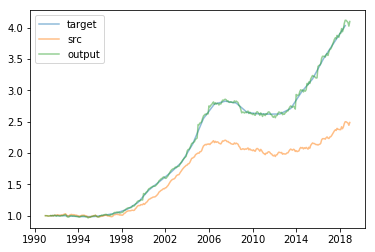

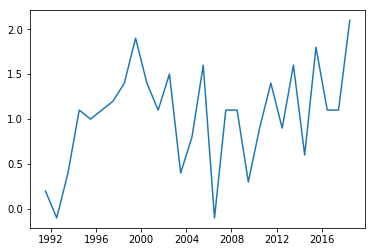

212 934


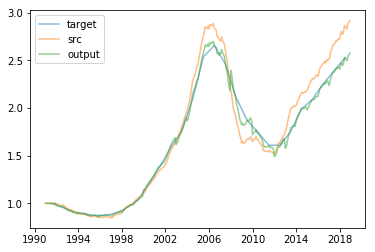

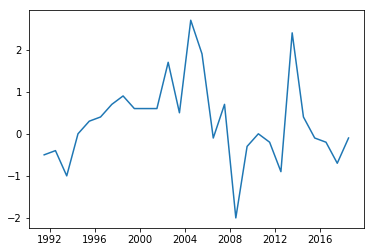

169 634


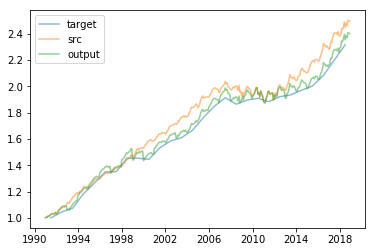

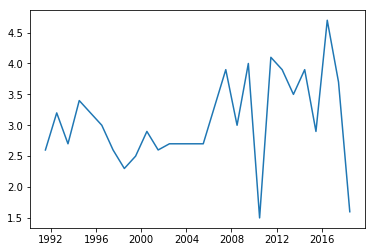

41 134


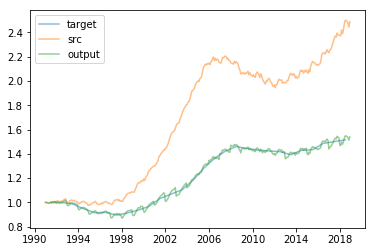

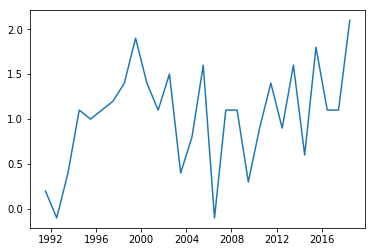

53 146


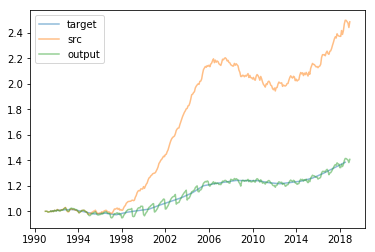

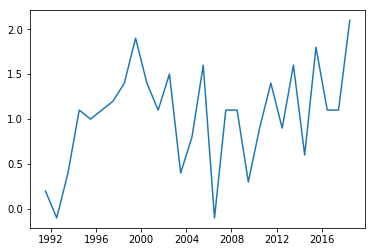

124 452


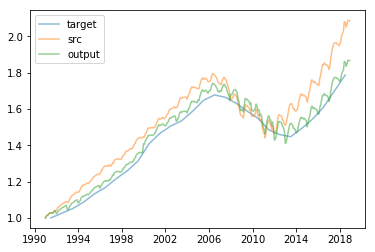

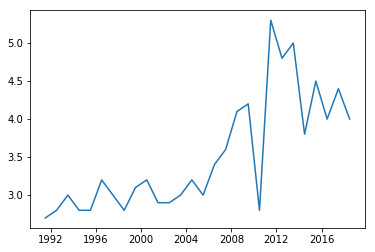

86 284


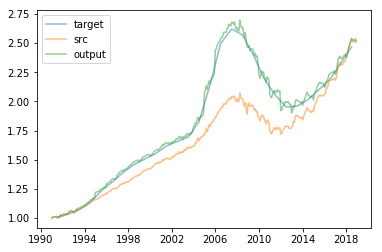

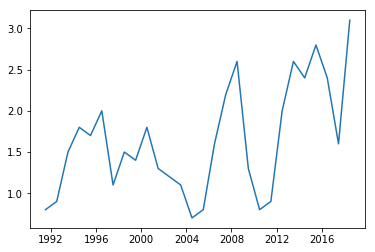

96 305


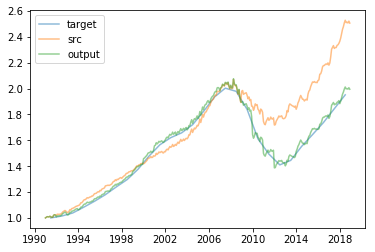

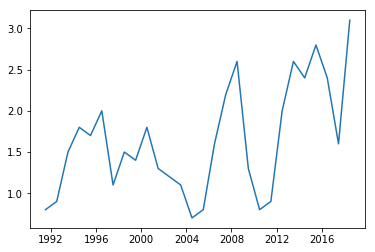

93 295


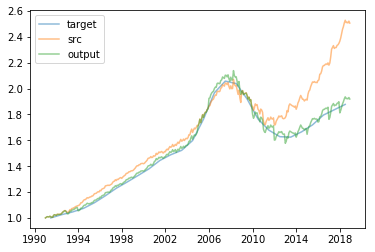

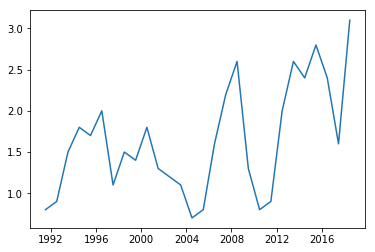

230 954


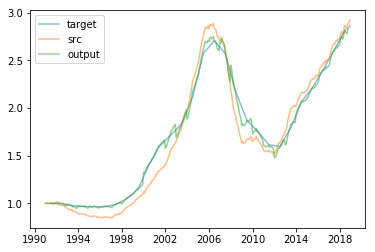

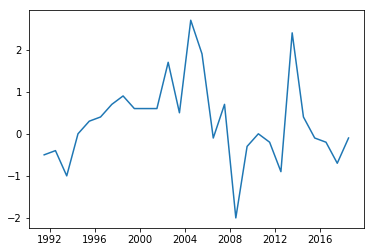

In [40]:
f=lambda u:u/u[0]
for i in np.random.choice(range(len(dest.columns)),10):
    print i, dest.columns[i] 
    plt.plot(f(target.iloc[:,i]),alpha=0.5)
    plt.plot(f(src.loc[:,zip3_to_state[dest.columns[i]]]),alpha=0.5)
    plt.plot(f(dest.iloc[:,i]),alpha=0.5)
    plt.legend(['target','src','output'])
    plt.show()
    plt.plot( np.round(100*(f(dest.iloc[:,i])/f(target.iloc[:,i])-1),1).dropna())
    plt.show()

In [41]:
dest.tail()

zip3               028         054         057         063         068  \
Month                                                                    
2018-08-01  212.964682  227.991914  161.393749  162.917906  196.790276   
2018-09-01  212.105577  227.072190  160.742683  162.260692  195.996419   
2018-10-01  211.197380  226.099908  160.054412  161.565921  195.157198   
2018-11-01  208.184973  222.874939  157.771481  159.261431  192.373580   
2018-12-01  211.994668  226.953455  160.658631  162.175846  195.893933   

zip3               070         072         074         076         100  \
Month                                                                    
2018-08-01  236.885646  191.120822  214.303372  235.457183  374.821746   
2018-09-01  235.930044  190.349836  213.438867  234.507343  373.309706   
2018-10-01  234.919835  189.534793  212.524961  233.503226  371.711263   
2018-11-01  231.569063  186.831369  209.493617  230.172660  366.409371   
2018-12-01  235.806677  190.250303  213.327261  234.384720  373.114504   

zip3           ...             954         955         956         957  \
Month          ...                                                       
2018-08-01     ...      278.558370  266.610020  224.273251  216.714456   
2018-09-01     ...      278.079649  266.151833  223.887822  216.342018   
2018-10-01     ...      283.334576  271.181358  228.118676  220.430277   
2018-11-01     ...      284.399785  272.200877  228.976298  221.258994   
2018-12-01     ...      286.857787  274.553446  230.955287  223.171284   

zip3               958         959         960         961         975  \
Month                                                                    
2018-08-01  226.980924  222.039149  208.223500  289.591702  293.868648   
2018-09-01  226.590843  221.657560  207.865654  289.094020  293.363615   
2018-10-01  230.872775  225.846268  211.793733  294.557088  298.907367   
2018-11-01  231.740752  226.695347  212.589982  295.664489  300.031123   
2018-12-01  233.743634  228.654623  214.427347  298.219848  302.624222   

zip3               976  
Month                   
2018-08-01  249.864902  
2018-09-01  249.435493  
2018-10-01  254.149126  
2018-11-01  255.104611  
2018-12-01  257.309421  

[5 rows x 240 columns]

In [42]:
dest.to_csv("../input/third2/HPI_at_zip3_monthly.csv")

# zip5 monthly

In [43]:
%reset -f

In [44]:
%pylab inline
import pandas as pd
import dask.dataframe as dd
import os,sys
import logging
import fastparquet
import gc
import cPickle as pickle 

Populating the interactive namespace from numpy and matplotlib


In [45]:
zip3_at_monthly=pd.read_csv("../input/third2/HPI_at_zip3_monthly.csv", parse_dates=['Month']).set_index('Month')


In [46]:
zip3_at_monthly.head()

028         054         057         063         068  \
Month                                                                    
1991-01-01  100.000000  100.000000  100.000000  100.000000  100.000000   
1991-02-01  100.040000  100.040000  100.040000  100.040000  100.040000   
1991-03-01   99.930000   99.930000   99.930000   99.930000   99.930000   
1991-04-01   99.330001   99.330001   99.330001   99.330001   99.330001   
1991-05-01   99.590001   99.590001   99.590001   99.590001   99.590001   

                   070         072         074         076         100  \
Month                                                                    
1991-01-01  100.000000  100.000000  100.000000  100.000000  100.000000   
1991-02-01  100.040000  100.040000  100.040000  100.040000  100.040000   
1991-03-01   99.930000   99.930000   99.930000   99.930000   99.930000   
1991-04-01   99.330001   99.330001   99.330001   99.330001   99.330001   
1991-05-01   99.590001   99.590001   99.590001   99.590001   99.590001   

               ...             954         955         956         957  \
Month          ...                                                       
1991-01-01     ...      100.000000  100.000000  100.000000  100.000000   
1991-02-01     ...      100.210000  100.210000  100.210000  100.210000   
1991-03-01     ...      100.000000  100.000000  100.000000  100.000000   
1991-04-01     ...       99.574089   99.574089   99.574089   99.574089   
1991-05-01     ...       99.812685   99.812685   99.812685   99.812685   

                   958         959         960         961         975  \
Month                                                                    
1991-01-01  100.000000  100.000000  100.000000  100.000000  100.000000   
1991-02-01  100.210000  100.210000  100.210000  100.210000  100.210000   
1991-03-01  100.000000  100.000000  100.000000  100.000000  100.000000   
1991-04-01   99.574089   99.574089   99.574089   99.574089   99.574089   
1991-05-01   99.812685   99.812685   99.812685   99.812685   99.812685   

                   976  
Month                   
1991-01-01  100.000000  
1991-02-01  100.210000  
1991-03-01  100.000000  
1991-04-01   99.574089  
1991-05-01   99.812685  

[5 rows x 240 columns]

In [47]:
assert zip3_at_monthly.isnull().sum().sum()==0

In [48]:
zip3_at_monthly.index.max()

Timestamp('2018-12-01 00:00:00')

In [49]:
zip5_at_hpi=pd.read_csv("../input/third2/HPI_AT_BDL_zip5_5state.csv", dtype={'zip5':np.str}).set_index("zip5").T
zip5_at_hpi.index=pd.to_datetime(['{}-07-01'.format(u) for u in zip5_at_hpi.index])

In [50]:
zip5_at_hpi.index.max()

Timestamp('2018-07-01 00:00:00')

In [51]:
zip5_at_hpi.head()

zip5         02891      05458      05734      05743      05764     05770  \
1991-07-01  148.84   99.82007  88.694600  102.02251  99.440640  79.47828   
1992-07-01  148.26  100.00000  86.936300  100.00000  97.469315  77.90269   
1993-07-01  145.44  101.64000  86.117710   94.54000  96.551540  77.16915   
1994-07-01  142.08   90.05000  84.272224   85.54000  94.482460  75.51543   
1995-07-01  144.60   98.35000  83.671590   84.51000  93.809060  74.97721   

zip5         06853   07002   07008      07020    ...       96130   96137  \
1991-07-01  114.98  299.99  182.58  86.381220    ...      153.59  118.99   
1992-07-01  113.66  310.86  189.61  86.870760    ...      160.61  124.31   
1993-07-01  117.12  297.35  180.61  87.763880    ...      164.33  132.70   
1994-07-01  114.89  314.16  177.27  87.938200    ...      168.11  136.97   
1995-07-01  119.35  279.09  178.71  87.551346    ...      185.98  128.81   

zip5            96140      96142   96145   96146   96150   96161      97523  \
1991-07-01  56.733833  52.674000  100.00  100.00  291.37  163.11   95.17639   
1992-07-01  58.732876  54.529995  110.26  107.94  302.28  169.15  100.00000   
1993-07-01  59.865803  55.581850  103.75  108.97  306.51  173.29  111.92000   
1994-07-01  60.843422  56.489510  105.70  112.76  313.99  173.23  113.65000   
1995-07-01  62.509956  58.036790  118.36  120.61  320.78  176.59  127.27000   

zip5            97623  
1991-07-01  55.879906  
1992-07-01  59.832200  
1993-07-01  61.908890  
1994-07-01  69.303840  
1995-07-01  73.471085  

[5 rows x 4088 columns]

In [52]:
src=zip3_at_monthly.sort_index()
target=zip5_at_hpi.sort_index()

In [53]:
from dateutil.relativedelta import relativedelta

In [54]:
def make_year(yr):
    return pd.to_datetime(['{}-{}-01'.format(yr,m) for m in range(1,13)])

In [55]:
def make_src_ratio(src,yr):
    quarter_dts1=make_year(yr)
    quarter_dts2=make_year(yr-1)
    return src.loc[quarter_dts1].values/src.loc[quarter_dts2].values


In [56]:
make_year(target.index[0].year)

DatetimeIndex(['1991-01-01', '1991-02-01', '1991-03-01', '1991-04-01',
               '1991-05-01', '1991-06-01', '1991-07-01', '1991-08-01',
               '1991-09-01', '1991-10-01', '1991-11-01', '1991-12-01'],
              dtype='datetime64[ns]', freq=None)

In [57]:
def make_series(src_s, target_s):
    lst=[]
    for i, dt in enumerate(target_s.index):
        dt=dt.year
        quarter_dts=make_year(dt)
        svs=src_s.loc[quarter_dts]
        if i==0:
            lst.append(svs.values)
        else:
            tv2=target_s.iloc[i]
            tv1=target_s.iloc[i-1]
            last_quarter=lst[-1]
            r=make_src_ratio(src_s,dt)
            k= tv2/tv1/np.mean(r)
            #k=np.exp(np.log(tv2/tv1) - np.mean(np.log(r)))
            
            #print last_quarter, r,k,tv2,tv1,k
            lst.append(k*r*last_quarter)
    lst=np.concatenate(lst,axis=0)
    return lst
            


In [58]:
len(target.columns)

4088

In [59]:
%%time 
dest=[]
for i, col in enumerate(target.columns[:]):
    if i%1000==0: print i,
    target_s=target[col]
    src_s=src[col[:3]]
    dest_s= make_series(src_s,target_s)
    dest.append(dest_s)
dest=pd.DataFrame( np.array(dest).T,columns=target.columns[:len(dest)],index=src.index)

0 1000 2000 3000 4000CPU times: user 2min 1s, sys: 1.08 s, total: 2min 2s
Wall time: 2min 1s



212 11366


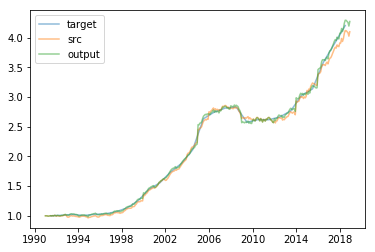

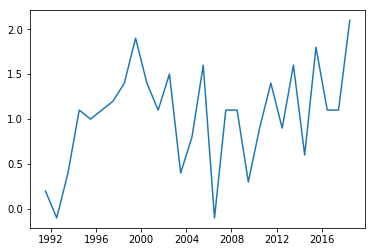

1428 28682


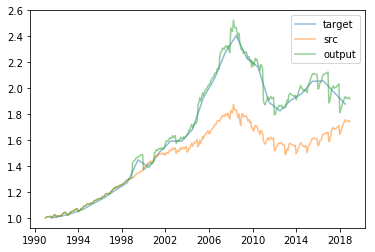

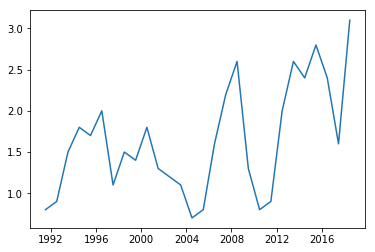

470 12304


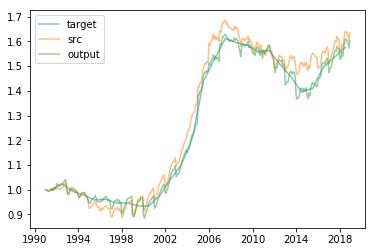

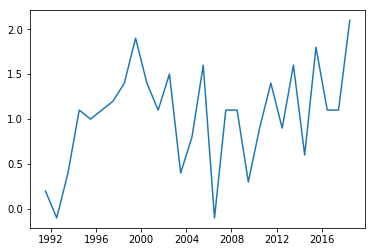

1632 43318


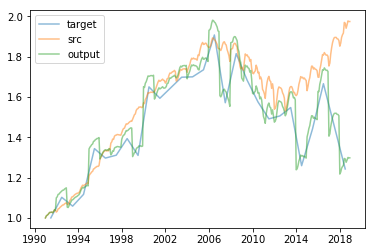

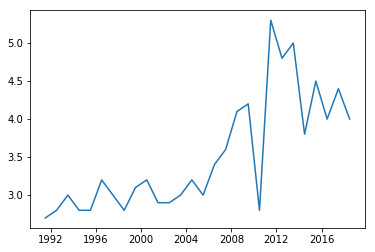

2362 45891


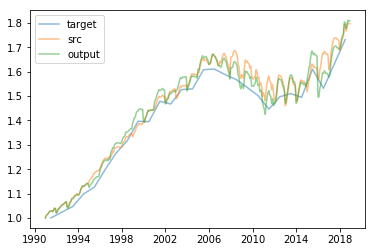

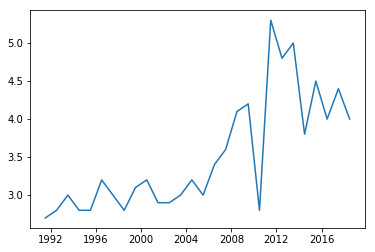

212 11366


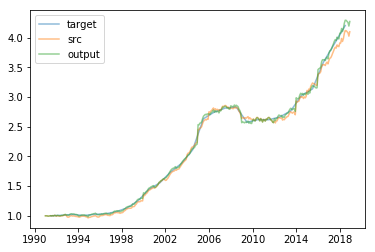

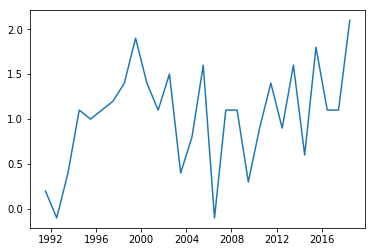

2029 44703


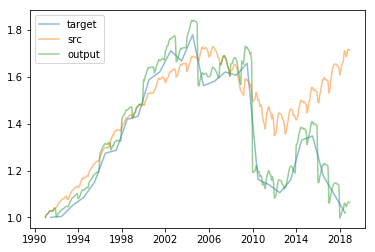

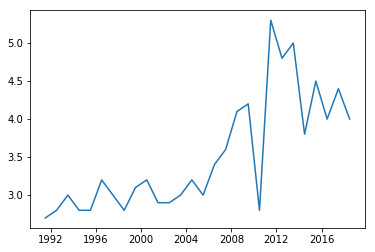

2720 52402


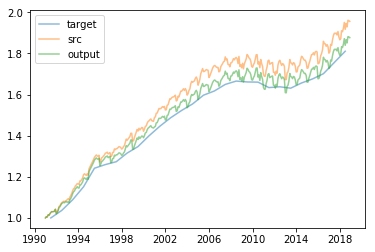

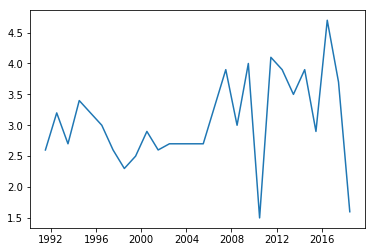

321 11743


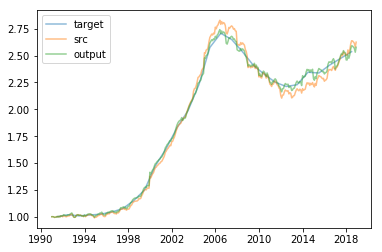

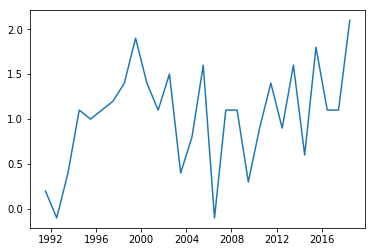

1490 28803


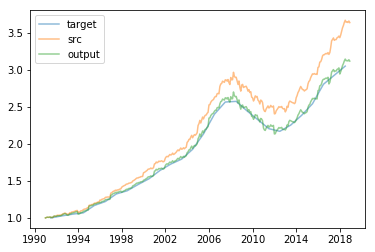

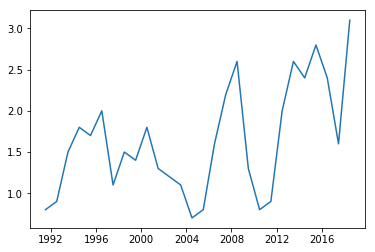

In [60]:
f=lambda u:u/u[0]
for i in np.random.choice(range(len(dest.columns)),10):
    print i, dest.columns[i] 
    plt.plot(f(target.iloc[:,i]),alpha=0.5)
    plt.plot(f(src.loc[:,dest.columns[i][:3]]),alpha=0.5)
    plt.plot(f(dest.iloc[:,i]),alpha=0.5)
    plt.legend(['target','src','output'])
    plt.show()
    plt.plot( np.round(100*(f(dest.iloc[:,i])/f(target.iloc[:,i])-1),1).dropna())
    plt.show()

In [61]:
dest.tail()

zip5             02891       05458       05734       05743       05764  \
Month                                                                    
2018-08-01  231.957533  236.149072  196.743922  148.447098  111.821138   
2018-09-01  231.021810  235.196441  195.950253  147.848259  111.370049   
2018-10-01  230.032618  234.189373  195.111230  147.215200  110.893183   
2018-11-01  226.751554  230.849020  192.328267  145.115400  109.311461   
2018-12-01  230.901010  235.073458  195.847791  147.770950  111.311814   

zip5             05770       06853       07002       07008       07020  \
Month                                                                    
2018-08-01  190.429097  289.620017  232.488883  215.730575  398.798245   
2018-09-01  189.660901  288.451683  231.551017  214.860312  397.189484   
2018-10-01  188.848808  287.216586  230.559558  213.940320  395.488791   
2018-11-01  186.155169  283.119881  227.270979  210.888789  389.847749   
2018-12-01  189.561729  288.300853  231.429940  214.747963  396.981795   

zip5           ...           96130       96137       96140       96142  \
Month          ...                                                       
2018-08-01     ...      191.140153  260.415664  335.610369  304.876308   
2018-09-01     ...      190.811666  259.968123  335.033601  304.352358   
2018-10-01     ...      194.417473  264.880793  341.364798  310.103766   
2018-11-01     ...      195.148394  265.876624  342.648175  311.269615   
2018-12-01     ...      196.835017  268.174534  345.609603  313.959846   

zip5             96145       96146       96150       96161       97523  \
Month                                                                    
2018-08-01  350.560058  318.679313  326.299075  357.173504  386.581516   
2018-09-01  349.957597  318.131642  325.738308  356.559678  385.917150   
2018-10-01  356.570816  324.143439  331.893851  363.297658  393.209905   
2018-11-01  357.911361  325.362072  333.141621  364.663492  394.688195   
2018-12-01  361.004705  328.174100  336.020886  367.815194  398.099394   

zip5             97623  
Month                   
2018-08-01  272.036074  
2018-09-01  271.568562  
2018-10-01  276.700448  
2018-11-01  277.740716  
2018-12-01  280.141165  

[5 rows x 4088 columns]

In [62]:
dest.to_csv("../input/third2/HPI_at_zip5_monthly.csv")